# CS156 Yosemite Village Yearly Weather
### Ang Li-Lian

In [1]:
import pandas as pd 
import numpy as np 
import random
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge, RidgeCV 

In [2]:
# Load data
years = range(2011, 2017)
files = ['CRNS0101-05-%d-CA_Yosemite_Village_12_W.txt' % y for y in years]
usecols = [1, 2, 8]

df = pd.DataFrame()

for filename in files:
    df = pd.concat([df, pd.read_csv(filename, usecols= usecols, header = None, delim_whitespace =True)])

df = df[df[8]>-50]

In [3]:
# Reshape date and time
df["YEAR"] = df[1].map(lambda x: x//10000)
df["DAY"]= df[1].map(lambda x: datetime.strptime(str(x), "%Y%m%d").timetuple().tm_yday)
df["TIME"] = df[2].map(lambda x:x//100*60+x%100)

In [4]:
# Split into train and test data
train = df[df["YEAR"]!=2016]
X_train, y_train = np.array(train[["DAY","TIME"]]), np.array(train[8]).reshape(-1,1)
train_day, train_time = np.array(train["DAY"]).reshape(-1,1), np.array(train["TIME"]).reshape(-1,1)

test = df[df["YEAR"]==2016]
X_test, y_test = np.array(test[["DAY","TIME"]]), np.array(test[8]).reshape(-1,1)
test_day, test_time = np.array(test["DAY"]).reshape(-1,1), np.array(test["TIME"]).reshape(-1,1)

# Linear Parameter Models
As we know, temperature is not linearly correlated for either the day of year or time of day. Attempting to fit a linear model to the above data would be an poor representation of the data. As a result, I will use a linear parameter model which is linear in its coefficients, but not in its variables.

$$ \phi(y) = w^T\phi(x)$$

where $\phi$ represents a function that will transform the variables into a non-linear relationship, $w$ represents the vector of coefficients which is linear.

Using a radial basis function as $\phi$, the function transforms each value by
$$ \phi(x) = exp(-1/\sigma ||x-m||^2)$$

where $m$ is a vector of centroids, $\sigma$ represents the variance of the Gaussian (how wide each Gaussian is).

Since the data goes on a time scale based on the day of the year or the time of day, we can select our centroids from evenly spaced points along the time scale. We will assign the each point to a centroid based on this.

Since the model is linear, we can use regression to fit a model to the training data. The difference is that the model will not necessarily a straight line, instead it can curve according to the new relationship defined by the radial basis function.


In [5]:
def rbf(data, sigma =1):
    # RBF Kernel
    m= np.linspace(np.min(data), np.max(data), 20).reshape(-1, 1)
    return rbf_kernel(data.reshape(-1,1), m, gamma = 1/sigma)

# Ridge Regression
We will use ridge regression here which opposed to regular ordinary least square regression has a penalty term $\alpha$ that allows for bias in the training model in return for lower variance on the testing set.


# Cross Validation
To determine the best $\sigma$ and $\alpha$ values to choose, we will perform cross-validation on the training set. The best values are determined based on $R^2$ score, where a higher score indicates better model fit. I have found that for the model to fit well $\sigma$ needs to be extremely large, in the magnitude of $10^{3}$. This is likely because the data is highly variable which is represented by the variance. Conversely $\alpha$ needs to be very small, in the magnitude of $10^{-3}$. This is likely because of the high variability, the model doesn't need to be so smoothed out. The low value allows the model to have more curves.

In [6]:
def parameters(X_set):
    # search for an parameters for RBF using CV
    k_scores = pd.DataFrame({
        "sigma":[],
        "alpha":[],
        "r2":[]
    })

    for sigma in np.arange(1000,25000, 1000):
        for alpha in np.arange(1,50, 1):
            x,y = rbf(X_set, sigma), y_train
            reg = Ridge(alpha=alpha)
            scores = cross_validate(reg, x, y, cv=3, scoring=["r2"])
            k_scores = k_scores.append({
                "sigma": sigma,
                "alpha": alpha,
                "r2": scores["test_r2"].mean()
            }, ignore_index = True)

    # parameters with highest R-squared
    K = k_scores["r2"].idxmax() 
    sigma, alpha = k_scores["sigma"].loc[K], k_scores["alpha"].loc[K]

    return sigma, alpha

# Yearly Model Component

The predicted temperature in blue follows the general shape of the actual temperature despite the high variability in the actual temperature, reflected as well in the relatively high R-squared score. To compensate for this, $\sigma$ is very large to mimic the actual variability. $\alpha$ is also relatively high because it makes the graph smoother by reducing the weightage given to the coefficients.

In [7]:
day_param = parameters(train_day)
day = Ridge(alpha=day_param[1])
day_transformed = rbf(train_day, day_param[0])
day.fit(day_transformed,y_train)
y_day = day.predict(rbf(test_day,day_param[0])) 

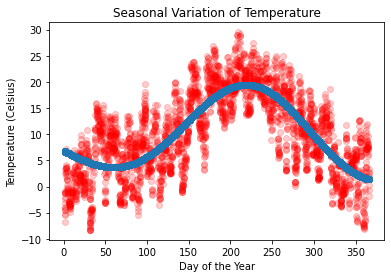

In [8]:
# Plot model
sample = np.random.randint(0, len(test_day), 3000)
plt.scatter(test_day[sample], y_test[sample], color = "red", alpha = 0.2)
plt.scatter(test_day[sample], y_day[sample])
plt.xlabel("Day of the Year")
plt.ylabel("Temperature (Celsius)")
plt.title("Seasonal Variation of Temperature")
plt.show()

In [9]:
print(f"R-squared for Day: {day.score(rbf(test_day, day_param[0]), y_test)}")
print(f"Alpha: {day_param[1]}")
print(f"Sigma: {day_param[0]}")

R-squared for Day: 0.5748953066889286
Alpha: 49.0
Sigma: 18000.0


# Daily Model Component

The variability in temperature here is much higher than for the yearly component. Although the predicted temperatures (blue) generally follows the trend of the temperatures, there sheer range of temperatures for each time stamp is simply too large for a line to capture. Therefore, we can see how the extremely low R-squared value reflects the poor fit of the model. Even with a high $\sigma$ and $\alpha$ value, there really isn't a feasible way to fit a line to this kind of data.

However, this graph still provides useful information about the temperature!

In [10]:
time_param = parameters(train_time)
time_transformed = rbf(train_time, time_param[0])
time = Ridge(alpha=time_param[1])
time.fit(time_transformed,y_train)
y_time = time.predict(rbf(test_time,time_param[0]))

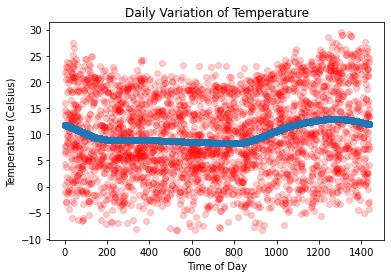

In [11]:
# Plot model
plt.scatter(test_time[sample], y_test[sample], color = "red", alpha = 0.2)
plt.scatter(test_time[sample], y_time[sample])
plt.xlabel("Time of Day")
plt.ylabel("Temperature (Celsius)")
plt.title("Daily Variation of Temperature")
plt.show()

In [12]:
print(f"R-squared for Time: {time.score(rbf(test_time, time_param[0]), y_test)}")
print(f"Alpha: {time_param[1]}")
print(f"Sigma: {time_param[0]}")

R-squared for Time: 0.04428657063055619
Alpha: 1.0
Sigma: 24000.0


# Full Model

I combined the above models using the same $\sigma$ values that yielded the best results for each model. For $\alpha$, I performed cross-validation here to determine the best value.

The R-squared value for the full model is higher than for individual models, especially the daily component model. It makes sense because both these variables are related and knowing one gives more information about the other. Merging the information given by both yields a much more accurate prediction. We can visually see these results when we compare the 3D graphs on the left and right on their general shape.

In [13]:
x = np.column_stack((day_transformed, time_transformed)) # combine models
reg =  RidgeCV(np.arange(1,50, 1)).fit(x, y_train)
test = np.column_stack((rbf(X_test[:,0], day_param[0]),rbf(X_test[:,1], time_param[0])))
y = reg.predict(test)

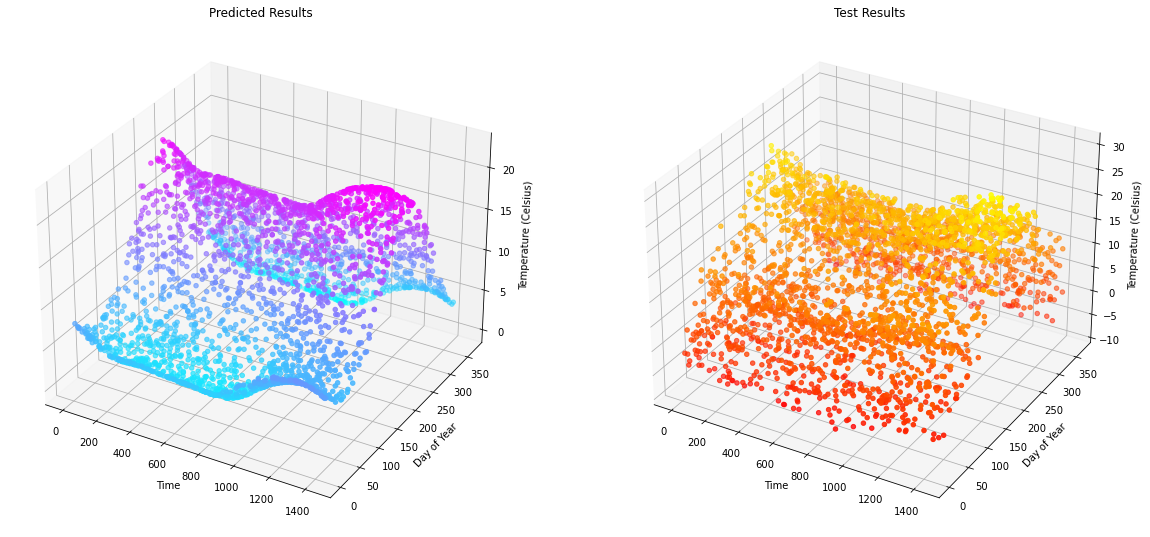

In [14]:
# Plot model
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(121,projection='3d')
sc1 = ax.scatter(X_test[sample][:,1], X_test[sample][:,0], y[sample], marker='o',cmap ="cool", c= y[sample])
ax.title.set_text("Predicted Results")
ax.set_xlabel('Time')
ax.set_ylabel('Day of Year')
ax.set_zlabel('Temperature (Celsius)')

ax = fig.add_subplot(122,projection='3d')
sc2 = ax.scatter(X_test[sample][:,1], X_test[sample][:,0], y_test[sample], marker='o',cmap ="autumn", c= y_test[sample])
ax.set_xlabel('Time')
ax.set_ylabel('Day of Year')
ax.set_zlabel('Temperature (Celsius)')
ax.title.set_text("Test Results")

In [15]:
print(f"R-squared for Model: {reg.score(test, y_test)}")

R-squared for Model: 0.6228773386573774
